<a href="https://colab.research.google.com/github/junieberry/ML-PerfectGuide/blob/main/05.%20%ED%9A%8C%EA%B7%80/06%20%EA%B7%9C%EC%A0%9C%20%EC%84%A0%ED%98%95%20%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 규제 선형 모델의 개요

- 비용 함수에만 최적화하게 되면 학습 데이터에 지나치게 맞추고, 회귀 계수가 쉽게 커짐
- RSS 최소와 회귀 계수 값을 커지지 않도록 하는 법의 균형을!




## 릿지 회귀

- 사이킷럿 Ridge 클래스



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# boston 데이타셋 로드
boston = load_boston()

# boston 데이타셋 DataFrame 변환 
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함. 
bostonDF['PRICE'] = boston.target
print('Boston 데이타셋 크기 :',bostonDF.shape)
bostonDF.head()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)

In [ ]:
# 앞의 LinearRegression예제에서 분할한 feature 데이터 셋인 X_data과 Target 데이터 셋인 Y_target 데이터셋을 그대로 이용 
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 folds 의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
 5 folds 의 평균 RMSE : 5.518 


In [ ]:
# Ridge에 사용될 alpha 파라미터의 값들을 정의
alphas = [0 , 0.1 , 1 , 10 , 100]

# alphas list 값을 iteration하면서 alpha에 따른 평균 rmse 구함.
for alpha in alphas :
    ridge = Ridge(alpha = alpha)
    
    #cross_val_score를 이용하여 5 fold의 평균 RMSE 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f} '.format(alpha,avg_rmse))


alpha 0 일 때 5 folds 의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330 


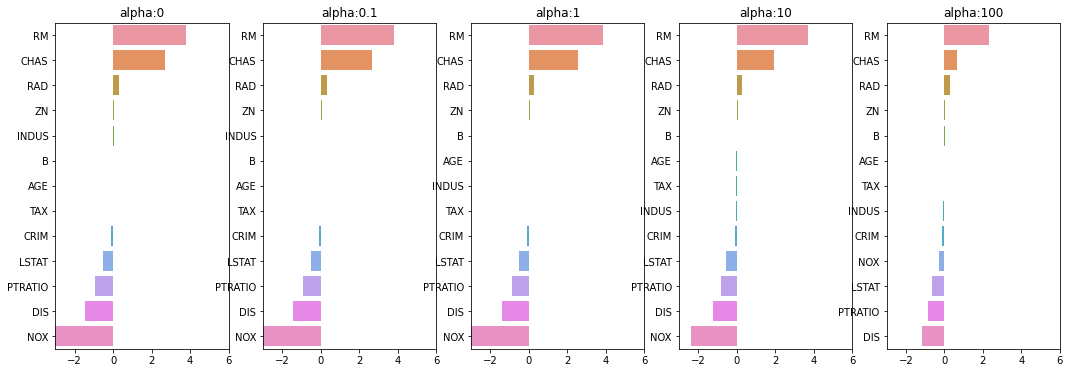

In [ ]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성  
fig , axs = plt.subplots(figsize=(18,6) , nrows=1 , ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성  
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.  
    coeff = pd.Series(data=ridge.coef_ , index=X_data.columns )
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

## 라쏘 회귀
L2 규제는 회귀 계수의 크기를 감소시키고

L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거

In [ ]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환 
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha=param)
        elif model_name =='Lasso': model = Lasso(alpha=param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, 
                                             y_target_n, scoring="neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        model.fit(X_data , y_target)
        # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
        coeff = pd.Series(data=model.coef_ , index=X_data.columns )
        colname='alpha:'+str(param)
        coeff_df[colname] = coeff
    return coeff_df
# end of get_linear_regre_eval

In [ ]:
# 라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df =get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189 


## 엘라스틱넷 회귀

L2 규제 + L1 규제

In [ ]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df =get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                      X_data_n=X_data, y_target_n=y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068 


## 선형 회귀 모델을 위한 데이터 변환

- 피처와 타깃값 간 선형 관계가 있다고 가정하고 예측
- 피처값과 타깃값의 분포가 정규 분포를 이룰 때 좋아함

1. StandardScaler로 표준 정규 분포 데이터셋
2. MinMaxScaler로 최솟값 0이고 최댓값 1인 값으로 정규화
3. 1,2 후 다항 변환
3. 로그 변환